<a href="https://www.kaggle.com/code/vedatgul/crm-analytics-cltv-prediction?scriptVersionId=123552351" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# What is customer lifetime value?

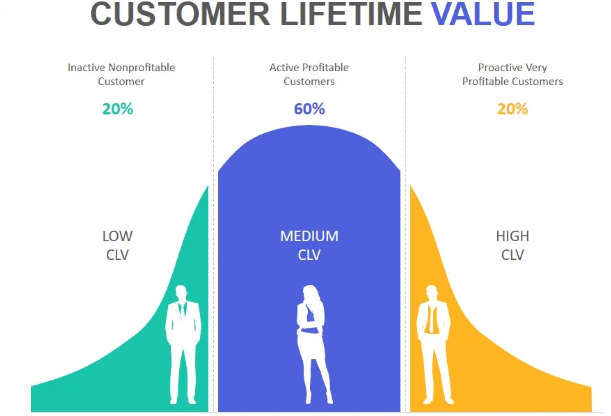

Customer lifetime value (Customer Lifetime Value, CLTV) is considered the monetary value that a customer will bring to a company during its relationship and communication with that company. If a company identifies the benefits that its customers can provide in the future, it can streamline its customer relationships and take a more value-added approach. A company that has calculated unit costs for acquiring new customers can compare customer lifetime value calculations with marketing activities aimed at existing customer bases and efforts to find new customers.

# How is customer lifetime value calculated?

* CLTV = (Customer Value / Churn Rate) * Profit Margin
* Customer Value = Average Order Value * Purchase Frequency
* Average Order Value = Total Price / Total Transaction
* Purchase Frequency = Total Transaction / Total Number of Customers
* Churn Rate = 1 — Repeat Rate (elde tutma oranı)
* Repeat Rate = Number of customers making multiple purchases / All customers
* Profit Margin = Total Price * 0.10


As a result, when groups are created by dividing from certain points according to the CLTV values to be calculated for each customer, customers will be segmented.


# CLTV Prediction

CLTV prediction is to capture the buying behavior of the whole audience in a data set and to make it possible to predict this when individual characteristics come.

CLTV = (BG/NBD Model) * (Gamma Gamma Submodel)

**BG/NBD (Beta Geometric / Negative Binomial Distribution) ile Expected Number of Transaction**

The BG/NBD Model probabilistically models two processes for the Expected Number of Transaction.
* Transaction Process (buy)
     * As long as it is alive, the number of transactions to be performed by a customer in a given time period is distributed with the transaction rate parameter.

     * As long as a customer is alive, they will continue to make random purchases around their transaction rate.

     * Transaction rates vary for each client and are gamma distributed (r,a) for the entire audience. The reception habit of the whole audience is different and everyone's transaction rate is different. We can make inferences and make probabilistic estimations over a variable and population whose distribution is known.
* Dropout Process (till you die)
  * Each customer has a dropout rate with probability p.
  * A customer drops with a certain probability after making a purchase.
  * Dropout rates vary for each client and beta is distributed for the entire audience (a,b)
  
**Gamma Gamma Submodel (Conditional Expected Average Profit) allows us to express the average amount of snow as probabilistic.**



# **About the dataset**

The dataset named Online Retail II includes the sales of a UK-based online store between 2010 and 2011. We are evaluating over the sales in the years 2010–2011.

**Variables¶**

**Invoice:** Invoice number. The unique number of each transaction, namely the invoice. Aborted operation if it starts with C.

**StockCode:** Product code. Unique number for each product.

**Description:** Product name

**Quantity:** Number of products. It expresses how many of the products on the invoices have been sold.

**InvoiceDate:** Invoice date and time.

**UnitPrice:** Product price (in GBP)

**CustomerID:** Unique customer number

**Country:** The country where the customer lives.

In [1]:
!pip install Lifetimes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 3.4 MB/s eta 0:00:00


In [2]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions
from sklearn.preprocessing import MinMaxScaler
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [3]:
df = pd.read_excel('/kaggle/input/uci-online-retail-ii-data-set/online_retail_II.xlsx', sheet_name='Year 2010-2011')
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.5500,17850.0000,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.7500,17850.0000,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom


In [4]:
# Specifying null values

df.isnull().sum()

Invoice             0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
Price               0
Customer ID    135080
Country             0
dtype: int64

In [5]:
# Deleting null values

df.dropna(inplace=True)

# Removal of canceled orders from the data set

df = df[~df["Invoice"].str.contains("C", na=False)]

# Getting the quantity and price values greater than 0

df = df[df["Quantity"] > 0]
df = df[df["Price"] > 0]

In [6]:
# Determination of outlier thresholds

def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

# Deletion of outliers

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = round(low_limit, 0)
    dataframe.loc[(dataframe[variable] > up_limit), variable] = round(up_limit, 0)

In [7]:
replace_with_thresholds(df, "Quantity")
replace_with_thresholds(df, "Price")
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.5500,17850.0000,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.7500,17850.0000,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom


In [8]:
# Calculating the total values of each transaction

df["TotalPrice"] = df["Quantity"] * df["Price"]
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.5500,17850.0000,United Kingdom,15.3000
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom,20.3400
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.7500,17850.0000,United Kingdom,22.0000
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom,20.3400
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom,20.3400


In [9]:
# Determination of analysis date

today_date = dt.datetime(2011, 12, 11)

**########################
Preparation of Lifetime Data Structure
###########################**

**recency:** The time elapsed since the last purchase. Weekly. (user specific)

**T:** The age of the customer. Weekly. (how long before the analysis date the first purchase was made)

**frequency:** total number of repeat purchases (frequency>1)

**monetary:** average earnings per purchase

In [10]:
cltv_df = df.groupby('Customer ID').agg(
    {'InvoiceDate': [lambda InvoiceDate: (InvoiceDate.max() - InvoiceDate.min()).days,
                    lambda InvoiceDate: (today_date - InvoiceDate.min()).days],
     'Invoice'    : lambda Invoice: Invoice.nunique(),
     'TotalPrice' : lambda TotalPrice: TotalPrice.sum()})

In [11]:
cltv_df.columns = cltv_df.columns.droplevel(0)

cltv_df.columns = ['recency', 'T', 'frequency', 'monetary']

cltv_df["monetary"] = cltv_df["monetary"] / cltv_df["frequency"]

cltv_df = cltv_df[(cltv_df['frequency'] > 1)]

cltv_df["recency"] = cltv_df["recency"] / 7

cltv_df["T"] = cltv_df["T"] / 7

# 1. Establishment of BG-NBD Model

In [12]:
# Determination of coefficients

bgf = BetaGeoFitter(penalizer_coef=0.001)

bgf.fit(cltv_df['frequency'],
        cltv_df['recency'],
        cltv_df['T'])

<lifetimes.BetaGeoFitter: fitted with 2845 subjects, a: 0.12, alpha: 11.41, b: 2.49, r: 2.18>

In [13]:
# Who are the customers we expect to purchase the most during the week?

cltv_df["expected_purc_1_week"] = bgf.predict(1,
                                              cltv_df['frequency'],
                                              cltv_df['recency'],
                                              cltv_df['T'])

In [14]:
# Who are the customers we expect to buy the most during 1 month?

cltv_df["expected_purc_1_month"] = bgf.predict(4,
                                               cltv_df['frequency'],
                                               cltv_df['recency'],
                                               cltv_df['T'])

In [15]:
# Who are the customers we expect to buy the most during 3 month?

cltv_df["expected_purc_3_month"] = bgf.predict(4 * 3,
                                               cltv_df['frequency'],
                                               cltv_df['recency'],
                                               cltv_df['T'])

In [16]:
cltv_df.head()

,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_purc_3_month
Customer ID,,,,,,,
12347.0000,52.1429,52.5714,7,615.7143,0.1413,0.5635,1.6784
12348.0000,40.2857,51.2857,4,442.5600,0.0920,0.3668,1.0920
12352.0000,37.1429,42.4286,8,219.4675,0.1824,0.7271,2.1631
12356.0000,43.1429,46.5714,3,937.1433,0.0862,0.3435,1.0222
12358.0000,21.2857,21.5714,2,575.0300,0.1223,0.4862,1.4388


#  2. Establishing the GAMMA-GAMMA Model

In [17]:
# Determination of coefficients

ggf = GammaGammaFitter(penalizer_coef=0.01)

ggf.fit(cltv_df['frequency'], cltv_df['monetary'])

<lifetimes.GammaGammaFitter: fitted with 2845 subjects, p: 3.79, q: 0.34, v: 3.73>

In [18]:
# Expected average profit

cltv_df["expected_average_profit"] = ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                                                             cltv_df['monetary'])

In [19]:
cltv_df.sort_values("expected_average_profit", ascending=False).head(10)

,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_purc_3_month,expected_average_profit
Customer ID,,,,,,,,
12415.0000,44.7143,48.2857,21,5723.7614,0.3796,1.5139,4.5080,5771.6321
12590.0000,0.0000,30.2857,2,4590.9800,0.0115,0.0460,0.1363,5029.2048
12435.0000,26.8571,38.2857,2,3914.9450,0.0763,0.3041,0.9035,4288.9406
12409.0000,14.7143,26.1429,3,3690.8900,0.1174,0.4674,1.3854,3918.8108
14088.0000,44.5714,46.1429,13,3864.5315,0.2603,1.0379,3.0896,3917.1059
18102.0000,52.2857,52.5714,60,3857.0120,0.9685,3.8636,11.5112,3868.2618
12753.0000,48.4286,51.8571,6,3571.5650,0.1261,0.5028,1.4973,3678.5774
14646.0000,50.4286,50.7143,73,3645.7085,1.2064,4.8119,14.3340,3654.4467
15749.0000,13.8571,47.5714,3,3023.7067,0.0280,0.1116,0.3320,3210.6659


# 3. Calculation of CLTV with BG-NBD and GG model

In [20]:
cltv = ggf.customer_lifetime_value(bgf,
                                   cltv_df['frequency'],
                                   cltv_df['recency'],
                                   cltv_df['T'],
                                   cltv_df['monetary'],
                                   time=3,  # 3 months
                                   freq="W",  # Frequency information of T
                                   discount_rate=0.01)
cltv = cltv.reset_index()
cltv.head()

,Customer ID,clv
0,12347.0000,1128.4474
1,12348.0000,538.6448
2,12352.0000,517.3235
3,12356.0000,1083.0897
4,12358.0000,966.3704


In [21]:
cltv_final = cltv_df.merge(cltv, on="Customer ID", how="left")
cltv_final.sort_values(by="clv", ascending=False).head(10)

,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_purc_3_month,expected_average_profit,clv
1122,14646.0000,50.4286,50.7143,73,3645.7085,1.2064,4.8119,14.3340,3654.4467,55735.4698
2761,18102.0000,52.2857,52.5714,60,3857.0120,0.9685,3.8636,11.5112,3868.2618,47379.0803
843,14096.0000,13.8571,14.5714,17,3163.5424,0.7287,2.8955,8.5526,3196.3894,29061.2374
36,12415.0000,44.7143,48.2857,21,5723.7614,0.3796,1.5139,4.5080,5771.6321,27682.4807
1257,14911.0000,53.1429,53.4286,201,691.6786,3.1264,12.4722,37.1641,692.2948,27376.1649
2458,17450.0000,51.2857,52.5714,46,2861.0689,0.7474,2.9815,8.8830,2871.9843,27145.1343
874,14156.0000,51.5714,53.1429,55,2103.8965,0.8775,3.5005,10.4298,2110.6236,23422.9533
2487,17511.0000,52.8571,53.4286,31,2933.8684,0.5088,2.0298,6.0476,2950.5049,18986.1282
2075,16684.0000,50.4286,51.2857,28,2209.2364,0.4781,1.9068,5.6801,2223.1476,13435.9567
650,13694.0000,52.7143,53.4286,50,1275.6430,0.8008,3.1946,9.5186,1280.1605,12965.5499


# 4. Creating Segments by CLTV

In [22]:
cltv_final["segment"] = pd.qcut(cltv_final["clv"], 4, labels=["D", "C", "B", "A"])

cltv_final.sort_values(by="clv", ascending=False).head(50)

cltv_final.groupby("segment").agg(
    {"count", "mean", "sum"})

Customer ID                     recency                        T                  frequency             monetary                   expected_purc_1_week                expected_purc_1_month                expected_purc_3_month                 expected_average_profit                         clv                   
               mean count           sum    mean count        sum    mean count        sum      mean count   sum     mean count         sum                 mean count      sum                  mean count      sum                  mean count       sum                    mean count         sum      mean count          sum
segment                                                                                                                                                                                                                                                                                                                         
D        15558.4761   712 11077635.0000 22.0738   712 15716.5714 40.4649   712 28811.0000    3.0646   712  2182 183.9537   712 130975.0318               0.0711   712  50.5898                0.2830   712 201.4774                0.8400   712  598.0905                199.4275   712 141992.3870  143.2919   712  102023.8666
C        15309.6343   711 10885150.0000 30.6697   711 21806.1429 38.1111   711 27097.0000    4.0956   711  2912 271.6890   711 193170.8954               0.1206   711  85.7309                0.4802   711 341.3936                1.4251   711 1013.2176                289.9793   711 206175.2655  380.7837   711  270737.2150
B        15352.8186   711 10915854.0000 29.5148   711 20985.0000 34.8117   711 24751.1429    5.4416   711  3869 373.4339   711 265511.5213               0.1625   711 115.5066                0.6465   711 459.6926                1.9165   711 1362.6595                393.8852   711 280052.3738  688.2502   711  489345.9077
A        14947.3586   711 10627572.0000 31.4109   711 22333.1429 34.4840   711 24518.1429   11.3586   711  8076 659.8045   711 469121.0327               0.2736   711 194.4993                1.0891   711 774.3298                3.2309   711 2297.1448                685.8436   711 487634.8242 2222.1219   711 1579928.6403